In [1]:
# import modules, define some functions for loading, saving and processing a gene-barcode matrix
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import h5py
from scipy import stats
import csv
from scipy import ndimage
from scipy import spatial

np.random.seed(0)

FeatureBCMatrix = collections.namedtuple('FeatureBCMatrix', ['feature_ids', 'feature_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename):
    with h5py.File(filename) as f:
        if u'version' in f.attrs:
            if f.attrs['version'] > 2:
                raise ValueError('Matrix HDF5 file format version (%d) is an newer version that is not supported by this function.' % version)
        else:
            raise ValueError('Matrix HDF5 file format version (%d) is an older version that is not supported by this function.' % version)
        
        feature_ids = [x.decode('ascii', 'ignore') for x in f['matrix']['features']['id']]
        feature_names = np.asarray([x.decode('ascii', 'ignore') for x in f['matrix']['features']['name']])    
        barcodes = np.asarray(list(f['matrix']['barcodes'][:]))
        matrix = sp_sparse.csc_matrix((f['matrix']['data'], f['matrix']['indices'], f['matrix']['indptr']), shape=f['matrix']['shape'])
        return FeatureBCMatrix(feature_ids, feature_names, barcodes, matrix)

def get_expression(fbm, gene_name):
    try:
        gene_index = fbm.feature_names.index(gene_name)
    except ValueError:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return fbm.matrix[gene_index, :].toarray().squeeze()
        
def subsample_matrix(gbm, barcode_indices):
    return FeatureBCMatrix(gbm.feature_ids, gbm.feature_names, gbm.barcodes[barcode_indices], gbm.matrix[:, barcode_indices])

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


10 clusters


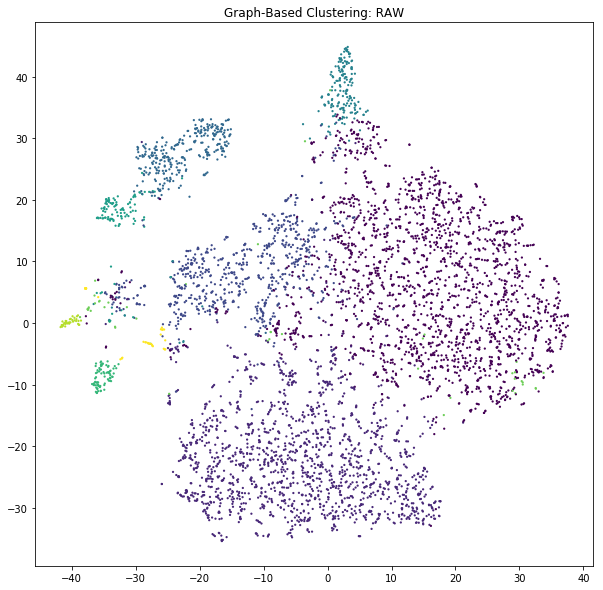

In [2]:
# Analyze all neurons clustered excluding FLARE genes (QC_excludegenes-FLARE.csv file)

folder='FLARE2'
project='Thy1L_Aggr'
dataset='Thy1L_Aggr'
params='_QC_neurons_excludeFLARE_params'
#savefolder='/media/storage/ckk/genomics/scripts/figs/NAc/'
savefolder='Z:/genomics/scripts/figs/NAc/'

#analysis_dir = '/media/storage/ckk/genomics/data/'+folder+'/reanalysis/'+project+'/'+dataset+params+'/outs/analysis/'
analysis_dir = 'Z:/genomics/data/'+folder+'/reanalysis/'+project+'/'+dataset+params+'/outs/analysis/'
tsne_file = analysis_dir+"tsne/2_components/projection.csv"

clusters_file = analysis_dir+'clustering/kmeans_10_clusters/clusters.csv'
diffexp_file = analysis_dir+'diffexp/kmeans_10_clusters/differential_expression.csv'
print('10 clusters')

# load TSNE and graph clustering
tsne = pd.read_csv(tsne_file)
clusters = pd.read_csv(clusters_file)

# plot all clusters in TSNE space
plt.figure(figsize=(10, 10))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=clusters['Cluster'], linewidths=0, s=5)
plt.title('Graph-Based Clustering: RAW')
plt.savefig(savefolder+project+params+'_tsneclust.eps', format='eps', dpi=1000)

del_barcodes=np.array([])

10


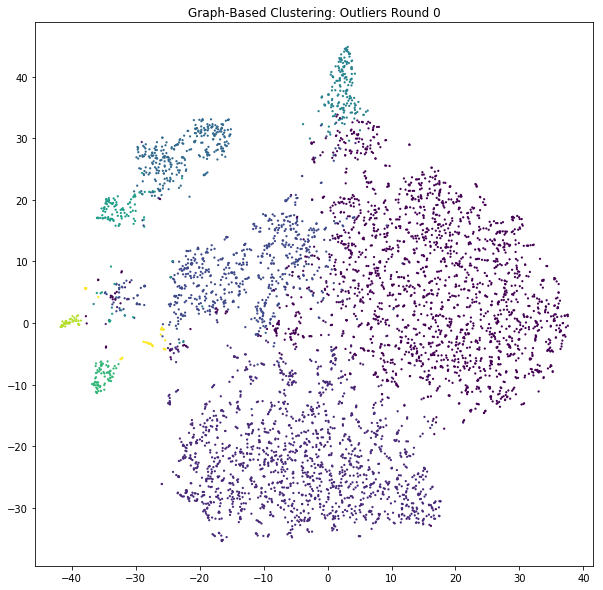

In [3]:
# Remove cluster 8 which looks like doublets/contaminants/junk

del_outliers_round0=np.array([])
del_barcodes_round0=np.array([])

for x in [8]:
    curr_clust=np.where(clusters['Cluster']==x)[0]
    
    del_outliers_round0=np.append(del_outliers_round0,np.asarray(curr_clust)).astype(int)
    del_barcodes_round0=np.append(del_barcodes_round0,clusters['Barcode'].iloc[curr_clust])

                                                               
clusters=clusters.drop(clusters.index[del_outliers_round0])
tsne=tsne.drop(tsne.index[del_outliers_round0])

# Plot Round 1 results
plt.figure(figsize=(10, 10))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=clusters['Cluster'], linewidths=0, s=5)
plt.title('Graph-Based Clustering: Outliers Round 0')
plt.savefig(savefolder+project+params+'_tsneclust.eps', format='eps', dpi=1000)


del_barcodes=del_barcodes_round0

print(max(clusters['Cluster']))

In [4]:
#matrices_dir = "/media/storage/ckk/genomics/data/"+folder+"/counts/"+project+"/"+dataset+"/outs/"
matrices_dir = "Z:/genomics/data/"+folder+"/counts/"+project+"/"+dataset+"/outs/"
file_matrix_h5 = matrices_dir+"filtered_feature_bc_matrix.h5"

gene_bc_matrix = get_matrix_from_h5(file_matrix_h5)

In [5]:
#barcodes_dir = "/media/storage/ckk/genomics/data/"+folder+"/reanalysis/"+project+"/Barcodes/"
barcodes_dir = "Z:/genomics/data/"+folder+"/reanalysis/"+project+"/Barcodes/"
barcodes_file=barcodes_dir+dataset+"_QC_neurons_barcodes.csv"


In [6]:
QCcell_barcodes=np.array([])    
with open(barcodes_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        QCcell_barcodes=np.append(QCcell_barcodes,row[0].encode('UTF-8'))
csv_file.close()
QCcell_barcodes=QCcell_barcodes[1:]

QC_cells=np.array([])
for x in range(0,len(QCcell_barcodes)):
    curr_barcodes=int(np.where(gene_bc_matrix.barcodes==QCcell_barcodes[x])[0])
    QC_cells=np.append(QC_cells,curr_barcodes)
QC_cells=QC_cells.astype(int)

print('Number of cells:',np.shape(QC_cells))

# Delete outlier barcodes
del_outliers=np.array([])
for x in range(0,len(del_barcodes)):
    curr_barcodes=np.where(QCcell_barcodes==del_barcodes[x].encode('UTF-8'))[0]
    del_outliers=np.append(del_outliers,curr_barcodes)
QC_cells=np.delete(QC_cells,del_outliers.astype(int))
QCcell_barcodes=np.delete(QCcell_barcodes,del_outliers.astype(int))

print(np.shape(QC_cells))
print(np.shape(clusters))

Number of cells: (5134,)
(5088,)
(5088, 2)


In [7]:
subset_matrix=subsample_matrix(gene_bc_matrix, QC_cells)

# Normalize matrix
subset_matrix_exp = subset_matrix.matrix.toarray().squeeze()
        
# Calculate total and median UMI counts per cell and normalize
total_umicounts_per_cell = np.sum(subset_matrix_exp, axis=0)
median_umicount_across_cells = np.median(total_umicounts_per_cell)
scale_factor = total_umicounts_per_cell/median_umicount_across_cells
subset_matrix_norm = subset_matrix_exp/scale_factor

# No normalization
#subset_matrix_norm = subset_matrix_exp

# Log transform data
#subset_matrix_norm = np.log2(subset_matrix_norm+1)

# Mean-center and scale variance per-gene
#mean_vals=np.nanmean(subset_matrix_norm,axis=1)
#mean_vals=np.reshape(mean_vals,(len(mean_vals),1))
#std_vals=np.nanstd(subset_matrix_norm,axis=1)
#std_vals=np.reshape(std_vals,(len(std_vals),1))
#subset_matrix_norm = (subset_matrix_norm - mean_vals)/std_vals

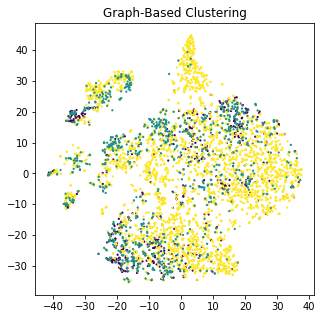

589
3554
945


In [8]:
barcodes = subset_matrix.barcodes
def splitGEMs(n): 
    return n[-1]

barcodes_last = np.asarray(list(map(splitGEMs, barcodes)))
group1=np.where(barcodes_last==49)[0]
group2=np.where(barcodes_last==50)[0]
group3=np.where(barcodes_last==51)[0]

groups=barcodes_last
groups[groups==49]=-1
groups[groups==50]=1
groups[groups==51]=0

# plot all clusters in TSNE space by group
plt.figure(figsize=(5, 5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=groups, linewidths=0, s=5, vmin=-1, vmax=1)
plt.title('Graph-Based Clustering')
plt.savefig(savefolder+project+params+'_groups.eps', format='eps', dpi=1000)
plt.show()

print(len(group1))
print(len(group2))
print(len(group3))

9


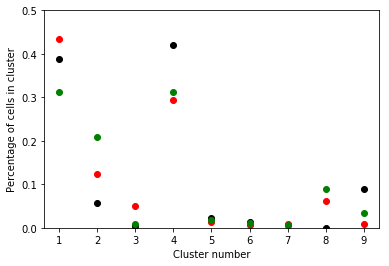

[[ 229.   33.    2.  248.   13.    8.    4.    0.   52.]
 [1543.  442.  178. 1045.   49.   23.   28.  219.   27.]
 [ 295.  198.    8.  295.   17.   10.    6.   84.   32.]]


In [9]:
num_clusters=len(np.unique(clusters['Cluster']))
print(num_clusters)

all_clusters=np.unique(clusters['Cluster'])
clust_order = [1,3,5,2,7,9,10,4,6] 

clust_groups=np.empty([3,num_clusters])
for x in range(0,num_clusters):
    curr_clust=np.where(clusters['Cluster']==clust_order[x])[0]
    total_clust=len(curr_clust)
    clust_groups[0,x]=len(np.where(np.isin(curr_clust,group1))[0])
    clust_groups[1,x]=len(np.where(np.isin(curr_clust,group2))[0])
    clust_groups[2,x]=len(np.where(np.isin(curr_clust,group3))[0])

plt.figure
plt.plot(np.arange(num_clusters)+1,clust_groups[0,:]/len(group1),'ok')
plt.plot(np.arange(num_clusters)+1,clust_groups[1,:]/len(group2),'or')
plt.plot(np.arange(num_clusters)+1,clust_groups[2,:]/len(group3),'og')
plt.ylabel('Percentage of cells in cluster')
plt.xlabel('Cluster number')
plt.ylim([0, 0.5])
plt.savefig(savefolder+project+params+'_groups_clusters.eps', format='eps', dpi=300)
plt.show()

print(clust_groups)

In [10]:
num_clusters=len(np.unique(clusters['Cluster']))

all_clusters=np.unique(clusters['Cluster'])

gene_index = np.where(subset_matrix.feature_names == "Gad2")[0]

clust_order = [1,2] 

for x in range(0,len(clust_order)):
    curr_clust=np.where(clusters['Cluster']==clust_order[x])[0]
    curr_counts=subset_matrix_exp[:,curr_clust]
    curr_counts_tta=subset_matrix_exp[-1,curr_clust]
    curr_counts_tev=subset_matrix_exp[-2,curr_clust]
    curr_counts_gad2=subset_matrix_exp[gene_index,curr_clust]
    sum_percell=np.sum(curr_counts, axis=0)
    #print(np.mean(sum_percell))
    print(np.mean(curr_counts_tta))
    #print(np.mean(curr_counts_tev))
    #print(np.mean(curr_counts_gad2))

        

0.9390420899854862
0.3545340050377834


1
Pdyn
3
Tshz1
5
Cxcl14
2
Adora2a
7
Pthlh
9
Sst
10
Slc5a7
4
Nrn1
6
Cck
['Drd1' 'Tshz1' 'Cxcl14' 'Adora2a' 'Pthlh' 'Sst' 'Slc5a7' 'Nrn1' 'Cck']


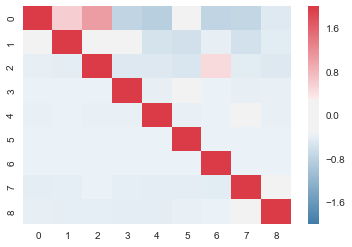

In [11]:
# Identify top most differentiating genes per cluster
num_clusters=len(np.unique(clusters['Cluster']))

all_clusters=np.unique(clusters['Cluster'])

clust_order = [1,3,5,2,7,9,10,4,6] 

# load TSNE and graph clustering
diffexp = pd.read_csv(diffexp_file)

diffgene_list=np.array([])
expression_matrix_perclust=np.empty([1,num_clusters])
#for x in range(0,num_clusters):
for x in clust_order:
    
    diffexp_sort=diffexp.sort_values(by=['Cluster '+str(x)+' Log2 fold change'],ascending=False)
    diffexp_nonzero=diffexp_sort[diffexp_sort['Cluster '+str(x)+' Mean Counts']>1]
    diffexp_sig=diffexp_nonzero[diffexp_nonzero['Cluster '+str(x)+' Adjusted p value']<0.1]
    currgenes=diffexp_sig.iloc[0,1]
    diffgene_list=np.append(diffgene_list,currgenes)
    print(x)
    print(currgenes)
    
diffgene_list[0]='Drd1'    
    
expression_matrix_perclust=np.zeros([len(diffgene_list),num_clusters])
for x in range(0,len(diffgene_list)):
    curr_gene = np.where(subset_matrix.feature_names == diffgene_list[x])[0]  
    for y in range(0,num_clusters):    
        curr_clust=np.where(clusters['Cluster']==[clust_order[y]])[0]
        currexpr = subset_matrix_norm[curr_gene,curr_clust] 
        expression_matrix_perclust[x,y]=np.mean(currexpr)
for x in range(0,len(diffgene_list)):
    expression_matrix_perclust[x,:]=stats.zscore(expression_matrix_perclust[x,:])   
    
print(diffgene_list)
    
# Plot heatmap of gene expression
import seaborn as sns

sns.set()
custom_map=sns.diverging_palette(240,10, sep=40, as_cmap=True)

plt.figure
sns.heatmap(expression_matrix_perclust, cmap=custom_map, vmin=-2, vmax=2)
plt.savefig(savefolder+project+params+'_topgene_heatmap.eps', format='eps', dpi=300)

1
1627      Pdyn
11114     Drd1
5122      Tac1
4360      Wfs1
688       Rgs4
3299     Calb1
Name: Feature Name, dtype: object
3
14021    Tshz1
5140     Foxp2
461      Lypd1
1476     Meis2
2406      Wbp5
685       Pbx1
Name: Feature Name, dtype: object
5
11156     Cxcl14
2757     Gucy1a3
8775        Nefl
5810        Ldhb
5122        Tac1
12716     Ppp1r2
Name: Feature Name, dtype: object
2
7256    Adora2a
3264       Penk
3809       Hpca
5547      Foxp1
3091      Gpr88
9377     Arpp19
Name: Feature Name, dtype: object
7
5837      Pthlh
6827     Cox6a2
12199     Pvalb
4477        Kit
5130      Nxph1
10553    Igfbp4
Name: Feature Name, dtype: object
9
12695        Sst
4730        Nos1
5304         Npy
11331      Crhbp
297       Resp18
3149     Col25a1
Name: Feature Name, dtype: object
10
13476     Slc5a7
7474     Slc17a8
4461     Slc10a4
352        Ecel1
2628       Trpc3
4934        Ache
Name: Feature Name, dtype: object
4
11028       Nrn1
1226        Rprm
6303     Slc17a7
12247      Nptxr

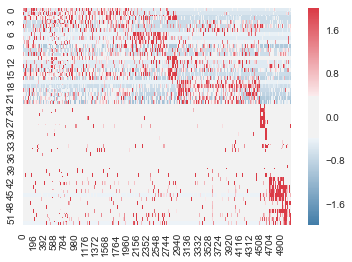

In [12]:
# Identify top 10 most differentiating genes per cluster and plot heatmap
clust_order = [1,3,5,2,7,9,10,4,6]

num_clusters=len(clust_order)


# load TSNE and graph clustering
diffexp = pd.read_csv(diffexp_file)

diffgene_list=np.array([])
for x in clust_order:
    diffexp_sort=diffexp.sort_values(by=['Cluster '+str(x)+' Log2 fold change'],ascending=False)
    diffexp_nonzero=diffexp_sort[diffexp_sort['Cluster '+str(x)+' Mean Counts']>1]
    diffexp_sig=diffexp_nonzero[diffexp_nonzero['Cluster '+str(x)+' Adjusted p value']<0.1]
    currgenes=diffexp_sig.iloc[0:6,1]
    diffgene_list=np.append(diffgene_list,currgenes)
    print(x)
    print(currgenes)

cell_list=np.array([])
#for x in range(0,num_clusters):
for x in clust_order:    
    curr_clust=np.where(clusters['Cluster']==x)[0]
    cell_list=np.append(cell_list,curr_clust).astype(int)   
    
expression_matrix=np.zeros([len(diffgene_list),len(cell_list)])
for x in range(0,len(diffgene_list)):    
    gene_index = np.where(subset_matrix.feature_names == diffgene_list[x])[0]
    currexpr = subset_matrix_norm[gene_index,:]
    currexpr = currexpr[0,cell_list]
    expression_matrix[x,:]=stats.zscore(currexpr)
    
# Plot heatmap of gene expression
sns.set()
custom_map=sns.diverging_palette(240,10, sep=50, as_cmap=True)

plt.figure
sns.heatmap(expression_matrix, cmap=custom_map, vmin=-2, vmax=2)
#plt.savefig(savefolder+project+'_heatmap.eps', format='eps', dpi=300)

1627         Pdyn
11114        Drd1
5122         Tac1
4360         Wfs1
688          Rgs4
3299        Calb1
9711      Tmem158
10533     Ppp1r1b
9138        Scn4b
12754       Adcy5
12824       Alcam
12836     Tomm70a
12942        Pcp4
5110      Ppp1r9a
11938       Crip2
11985        Sub1
12982      Pde10a
10845      Baiap2
12716      Ppp1r2
9340         Tpm1
968          Gad2
9207       Elmod1
3896     Sh3bgrl3
3177       Ppp3ca
6725        Prkcb
1737       Fkbp1a
4930        Ap1s1
9635       Arpp21
12034      Zfp706
Name: Feature Name, dtype: object
[3.0125027144162737, 2.5121056326199858, 1.9382931622040165, 1.1757327450340258, 0.9402144515317592, 0.743911152494366, 0.6821264815439259, 0.6687498259613902, 0.6531364080603835, 0.5866837982150421, 0.5863613601272332, 0.5676571539719972, 0.5466517563555966, 0.5465327872284275, 0.5194383566963217, 0.5026238028299752, 0.4292638486577422, 0.4259831574705189, 0.4257440979148291, 0.42511486758472294, 0.4250583716779299, 0.4249770294828337, 0.3

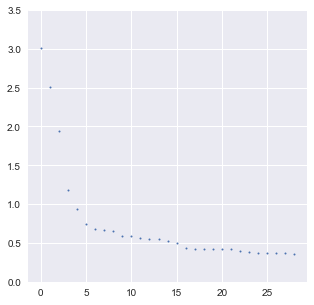

In [13]:
# plot sig genes for D1 MSN cluster

curr_clust = 1

# load TSNE and graph clustering
diffexp = pd.read_csv(diffexp_file)

D1diffexp_sort=diffexp.sort_values(by=['Cluster '+str(curr_clust)+' Log2 fold change'],ascending=False)
D1diffexp_nonzero=D1diffexp_sort[(D1diffexp_sort['Cluster '+str(curr_clust)+' Mean Counts']>1) & (D1diffexp_sort['Cluster '+str(curr_clust)+' Log2 fold change']>0)]
D1diffexp_sig=D1diffexp_nonzero[D1diffexp_nonzero['Cluster '+str(curr_clust)+' Adjusted p value']<0.1]
D1diffgene_list=D1diffexp_sig.iloc[:,1]
D1foldchanges=list(D1diffexp_sig['Cluster '+str(curr_clust)+' Log2 fold change'])

#D1diffexp_nonzero_neg=D1diffexp_sort[(D1diffexp_sort['Cluster '+str(curr_clust)+' Mean Counts']>1) & (D1diffexp_sort['Cluster '+str(curr_clust)+' Log2 fold change']<0)]
#D1diffexp_sig_neg=D1diffexp_nonzero_neg[D1diffexp_nonzero_neg['Cluster '+str(curr_clust)+' Adjusted p value']<0.1]
#D1diffgene_list_neg=D1diffexp_sig_neg.iloc[:,1]
#D1foldchanges_neg=list(D1diffexp_sig_neg['Cluster '+str(curr_clust)+' Log2 fold change'])

#D1diffgene_list=np.append(D1diffgene_list, D1diffgene_list_neg)
#D1foldchanges=np.append(D1foldchanges, D1foldchanges_neg)

print(D1diffgene_list)
print(D1foldchanges)
print(len(D1foldchanges))

plt.figure(figsize=(5, 5))
xaxis=np.arange(0,len(D1foldchanges))
plt.scatter(xaxis, D1foldchanges, linewidths=0, s=4)
plt.ylim([0, 3.5])
plt.savefig(savefolder+project+'_D1MSN1_siggenes.eps', format='eps', dpi=1000)



Text(0.5,0,'Cluster')

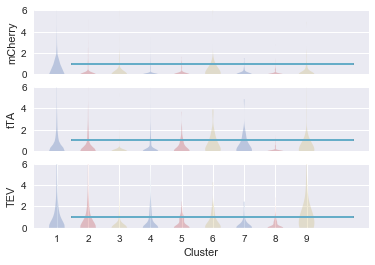

In [14]:
# Plot violinplots of FLARE components across clusters
FLAREgene_list=np.array(["mCherry","tTA","TEV"])
num_genes=len(FLAREgene_list)
maxval=np.zeros((num_clusters,num_genes))
plt.figure
for y in range(0,num_genes):
    gene_index = np.where(subset_matrix.feature_names == FLAREgene_list[y])[0]
    gene_expr = subset_matrix_norm[gene_index,:]
    plt.subplot(num_genes,1,y+1)
    for x in range(0,num_clusters):
        curr_clust=np.where(clusters['Cluster']==clust_order[x])[0]
        currexpr = gene_expr[0,curr_clust]
        currexpr = currexpr[currexpr<100]
        #print(np.sort(currexpr))
        #print(len(currexpr))
        plt.violinplot(currexpr,[x],showextrema=False)
        plt.plot([0.5,9.5],[1, 1])
        plt.ylim(0,6)
        maxval[x,y]=np.percentile(currexpr,99)
    plt.ylabel(FLAREgene_list[y])
    plt.xticks([])
    #plt.grid(False)

#for y in range(0,num_genes):
#    plt.subplot(num_genes,1,y+1)
#    plt.ylim(0,np.max(maxval[:,y]))
#    print(np.max(maxval[:,y]))
plt.xticks(np.arange(0,num_clusters),np.arange(1,num_clusters+1))
plt.xlabel('Cluster')        
#plt.savefig(savefolder+project+'_neurons_FLAREgenes_violinplots.eps', format='eps', dpi=1000)

TEV
1
[ 51. 460. 127.]
2
[  7. 106.  50.]
3
[ 0. 16.  0.]
4
[ 40. 205. 100.]
5
[4. 6. 2.]
6
[2. 3. 3.]
7
[1. 3. 0.]
8
[17.  6.]
9
[20. 11. 10.]
tTA
1
[ 36. 317.  69.]
2
[ 2. 66. 39.]
3
[0. 5. 0.]
4
[ 35. 114.  54.]
5
[2. 6. 2.]
6
[3. 2. 5.]
7
[2. 5. 1.]
8
[2. 2.]
9
[5. 8. 3.]
mCherry
1
[ 14. 149.  24.]
2
[ 1. 46.  2.]
3
[ 0. 13.  0.]
4
[10. 62. 10.]
5
[0. 4. 0.]
6
[0. 2. 1.]
7
[1. 1. 0.]
8
[6. 0.]
9
[2. 3. 1.]
1.33854879826354
212.66666666666666


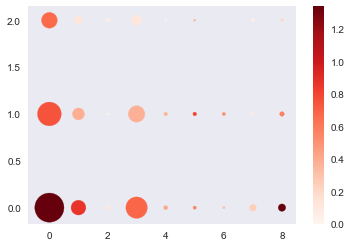

In [16]:
# Dotplot of FLARE components across clusters

FLAREgene_list=np.array(["TEV","tTA","mCherry"])
num_genes=len(FLAREgene_list)
num_reps=3
groups=[49,50,51]
barcodes_last = np.asarray(list(map(splitGEMs, barcodes)))

meanexpr=np.zeros([num_genes,num_clusters])
meancounts=np.zeros([num_genes,num_clusters])

for y in range(0,num_genes):
    gene_index = np.where(subset_matrix.feature_names == FLAREgene_list[y])[0]
    gene_expr = subset_matrix_norm[gene_index,:]
    print(FLAREgene_list[y])
    for x in range(0,num_clusters):
    #for x in [3]:
        currmean=np.array([])
        currcount=np.array([])
        print(x+1)
        for z in range(0,num_reps):
            curr_clust=np.where(clusters['Cluster']==clust_order[x])[0]
            curr_rep=np.where(barcodes_last==groups[z])[0]
            curr_clust=curr_clust[np.isin(curr_clust,curr_rep)]
            curr_expr=gene_expr[0,curr_clust]
            if len(curr_expr)>0:
                currmean = np.append(currmean, np.mean(curr_expr))
                currcount = np.append(currcount, len(curr_expr[curr_expr>=1]))
        print(currcount)
        meanexpr[y,x]=np.mean(currmean)
        meancounts[y,x]=np.mean(currcount)
        
maxval=np.max(meanexpr)
print(maxval)
print(np.max(meancounts))
xaxis=range(0,num_clusters)

for y in range(0,num_genes):
    currcolor=np.asarray(meancounts[y,:])
    plt.scatter(xaxis,np.ones(num_clusters)*y,s=meancounts[y,:]*4,c=meanexpr[y,:],cmap=plt.cm.Reds,vmin=0,vmax=maxval)
plt.grid(False)
plt.colorbar()
plt.savefig(savefolder+project+'_FLAREcomponents_scaleddotheatplot.eps', format='eps', dpi=1000)


C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: 

[3.98028273 2.92785529 5.74346415 2.00237971 1.26439931 4.39253022
 1.34495622 1.21798019 2.0254394 ]
[7.15396501 2.2896078  2.45236277 8.02332197 1.41695175 3.13575473
 1.27245691 1.40869497 1.86345648]
[4.36741232 4.75495873 7.66773008 5.24322834 3.50700216 6.1106407
 1.89619008 7.04079441 4.91973423]
[19.54585718 17.40597365 27.33081308  4.85431848  1.60016114  8.20315239
  3.44805376  2.08230012  1.61616256]
[ 5.35373273 12.31270587  5.16383353  2.67068117  1.02971374  1.03451109
  3.16375702  1.29018137  3.25121917]
[13.49569182 17.95704614  6.02379244 37.77987494  2.44175923  3.47571811
  6.82407187  7.2532053   3.73172265]


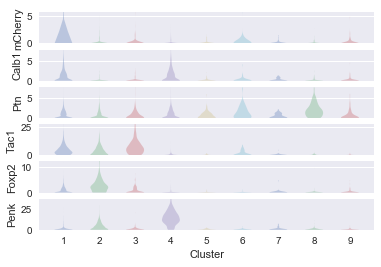

In [17]:
# Plot violinplots of sig diff genes across clusters

siggene_list=np.array(["mCherry","Calb1","Ptn","Tac1","Foxp2","Penk"])
num_sig=len(siggene_list)
maxval=np.zeros((num_clusters,num_sig))
plt.figure
clust_order = [1,3,5,2,7,9,10,4,6] 

for y in range(0,num_sig):
    gene_index = np.where(subset_matrix.feature_names == siggene_list[y])[0]
    gene_expr = subset_matrix_norm[gene_index,:]
    plt.subplot(num_sig,1,y+1)
    for x in range(0,num_clusters):
        curr_clust=np.where(clusters['Cluster']==clust_order[x])[0]
        currexpr = gene_expr[0,curr_clust]
        plt.violinplot(currexpr,[x],showextrema=False)
        maxval[x,y]=np.percentile(currexpr,99)
    plt.ylabel(siggene_list[y])
    plt.xticks([])
#print(num_sig)
#print(maxval)
        
for y in range(0,num_sig):
    plt.subplot(num_sig,1,y+1)
    plt.ylim(0,np.max(maxval[:,y]))
    print(maxval[:,y])
plt.xticks(np.arange(0,num_clusters),np.arange(1,num_clusters+1))
plt.xlabel('Cluster')
plt.grid(False)
plt.savefig(savefolder+project+params+'_violinplots_FLARE+clustergenes_mappedonneurons.eps', format='eps', dpi=1000)

1
1
Number of neurons:  5088
Number of FLARE+ neurons:  1548


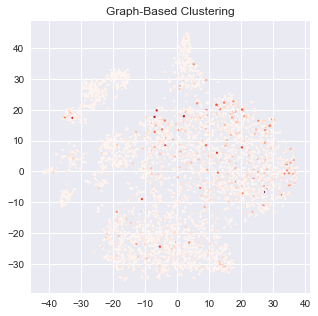

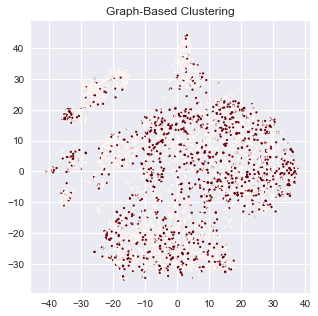

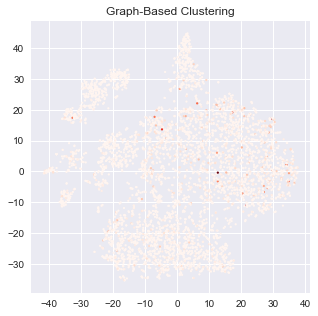

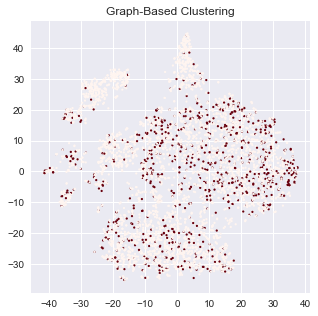

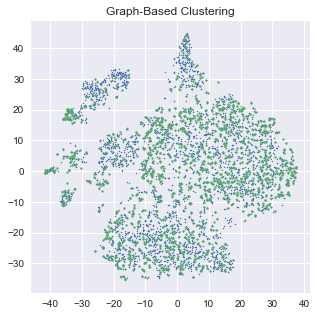

In [18]:
# Define FLARE cells as needing to have >1 expression EITHER TEVp OR tTA enrichment 

gene_list=np.array(["TEV","tTA"])

FLARE_cells=np.array([])
for x in range(0,len(gene_list)):
    gene=np.where(subset_matrix.feature_names == gene_list[x])[0]
    gene_expr=np.asarray(subset_matrix_norm[gene, :])[0]
    
    thresh=1
    print(thresh)
    
    # plot all clusters in TSNE space by group
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=gene_expr, linewidths=0, s=5,cmap=plt.cm.Reds)
    plt.title('Graph-Based Clustering')
    
    gene_expr_thresh=gene_expr
    gene_expr_thresh[np.where(gene_expr<thresh)[0]]=0
    cells=np.where(gene_expr>=thresh)[0]
        
    # plot all clusters in TSNE space by group
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=gene_expr_thresh, linewidths=0, s=5,cmap=plt.cm.Reds,vmin=0,vmax=thresh)
    plt.title('Graph-Based Clustering')

    FLARE_cells=np.append(FLARE_cells,np.asarray(cells)).astype(int)
    
FLARE_cells=np.unique(FLARE_cells)

print("Number of neurons: ",len(QC_cells))
print("Number of FLARE+ neurons: ",len(FLARE_cells))

plt.figure(figsize=(5, 5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], linewidths=0, s=2,cmap=plt.cm.Reds)
plt.scatter(tsne['TSNE-1'].iloc[FLARE_cells], tsne['TSNE-2'].iloc[FLARE_cells], linewidths=0, s=5,cmap=plt.cm.Reds)
plt.title('Graph-Based Clustering')
#plt.savefig(savefolder+project+params+'_FLARE+neurons_thresholded1.eps', format='eps', dpi=1000)
plt.show()

1
Number of mCherry+ neurons:  352
Number of mCherry+ FLARE neurons:  210
Fraction of FLARE neurons that are mCherry+:  0.13565891472868216


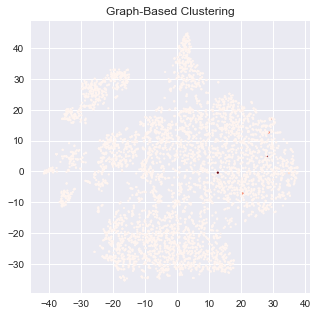

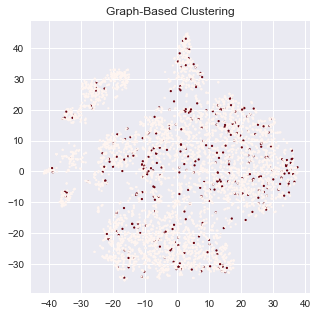

In [19]:
# Find mCherry+ neurons >1 expression for enrichment

gene_list=np.array(["mCherry"])

mCherry_gene=np.where(subset_matrix.feature_names == "mCherry")[0]
mCherry_expr=np.asarray(subset_matrix_norm[mCherry_gene, :])[0]
thresh=1
print(thresh)

# plot all clusters in TSNE space by group
plt.figure(figsize=(5, 5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=mCherry_expr, linewidths=0, s=5,cmap=plt.cm.Reds)
plt.title('Graph-Based Clustering')
    
mCherry_expr_thresh=mCherry_expr
mCherry_expr_thresh[np.where(mCherry_expr<thresh)[0]]=0
        
# plot all clusters in TSNE space by group
plt.figure(figsize=(5, 5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=mCherry_expr_thresh, linewidths=0, s=5,cmap=plt.cm.Reds,vmin=0,vmax=thresh)
plt.title('Graph-Based Clustering')

mCherry_cells=np.where(mCherry_expr>=thresh)[0]
mCherry_FLARE=mCherry_cells[np.isin(mCherry_cells,FLARE_cells)]
fraction_mCherry_all=len(mCherry_FLARE)/len(FLARE_cells)
print("Number of mCherry+ neurons: ",len(mCherry_cells))
print("Number of mCherry+ FLARE neurons: ",len(mCherry_FLARE))
print("Fraction of FLARE neurons that are mCherry+: ",fraction_mCherry_all)

Cluster [1]
138
187
Cluster [2]
21
49
Cluster [3]
2
13
Cluster [4]
40
82
Cluster [5]
1
4
Cluster [6]
1
3
Cluster [7]
2
2
Cluster [8]
1
6
Cluster [9]
4
6


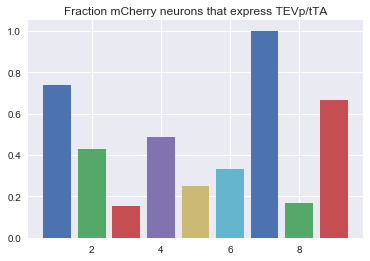

In [20]:
# Calculate fraction of mCherry neurons that also express TEVp/tTA (per cluster)
plt.figure
plt.title('Fraction mCherry neurons that express TEVp/tTA')

for x in range(0,num_clusters):
    print('Cluster',[x+1])

    curr_clust=np.where(clusters['Cluster']==clust_order[x])[0]
    curr_mCherry=len(mCherry_cells[np.isin(mCherry_cells,curr_clust)])
    curr_mCherryF=len(mCherry_FLARE[np.isin(mCherry_FLARE,curr_clust)])
    print(curr_mCherryF)
    print(curr_mCherry)
    plt.bar(x+1,curr_mCherryF/curr_mCherry)
plt.savefig(savefolder+project+'_mCherryFvsmCherry.eps', format='eps', dpi=1000)    

Cluster [1]
66
14
557
149
138
24
Cluster [2]
7
1
131
46
68
2
Cluster [3]
0
0
20
13
0
0
Cluster [4]
62
10
259
62
123
10
Cluster [5]
5
0
11
4
4
0
Cluster [6]
4
0
5
2
6
1
Cluster [7]
3
1
7
1
1
0
Cluster [8]
0
0
19
6
8
0
Cluster [9]
21
2
13
3
10
1


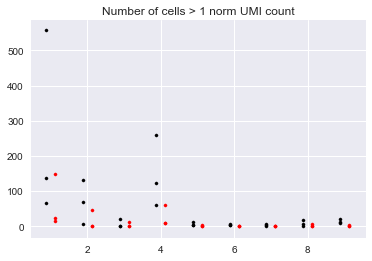

In [21]:
# Plot number of cells that express TEVp/tTA or mCherry per cluster

plt.figure
plt.title('Number of cells > 1 norm UMI count')

num_reps=3
groups=[49,50,51]
barcodes_last = np.asarray(list(map(splitGEMs, barcodes))) 
width=0.25
for x in range(0,num_clusters):
    print('Cluster',[x+1])
    
    for y in range(0,num_reps):
        curr_clust=np.where(clusters['Cluster']==clust_order[x])[0]
        curr_rep=np.where(barcodes_last==groups[y])[0]
        curr_clust=curr_clust[np.isin(curr_clust,curr_rep)]
        curr_FLARE=len(FLARE_cells[np.isin(FLARE_cells,curr_clust)])
        #curr_mCherry=len(mCherry_FLARE[np.isin(mCherry_FLARE,curr_clust)])
        curr_mCherry=len(mCherry_cells[np.isin(mCherry_cells,curr_clust)])
        print(curr_FLARE)
        print(curr_mCherry)
        plt.scatter(x+1-(width/2), curr_FLARE, s=10, label='FLARE',color='k',)
        plt.scatter(x+1+(width/2), curr_mCherry, s=10, label='mCherry',color='r')
        
        #print(curr_FLARE)
        #print(curr_mCherry)
        
#plt.ylim(0,150)
#plt.savefig(savefolder+project+'_FLARE+neurons_thresh1_dotplot.eps', format='eps', dpi=1000)

#plt.ylim(0,30)
plt.savefig(savefolder+project+'_FLARE+_mCherry+neurons_thresh1_dotplot.eps', format='eps', dpi=1000)

In [ ]:
# Calculate mCherry enrichment per cluster

# remove cluster 5 (order 3, D1 matrix) and 4 (order 8, cortex ex) because too few FLARE+ cells
num_reps=3
groups=[49,50,51]
keep_clusters=[0,1,3,4,5,8] #thresh 1
num_clusters_keep=len(keep_clusters)
barcodes_last = np.asarray(list(map(splitGEMs, barcodes))) 
mCherry_enrich=np.zeros((num_reps,num_clusters_keep))
for x in range(0,num_clusters_keep):
    print('Cluster',keep_clusters[x]+1)
    for y in range(0,num_reps):
        curr_clust=np.where(clusters['Cluster']==clust_order[keep_clusters[x]])[0]
        curr_rep=np.where(barcodes_last==groups[y])[0]
        curr_clust=curr_clust[np.isin(curr_clust,curr_rep)]
        curr_clust=curr_clust[np.isin(curr_clust,FLARE_cells)]
        print('# FLARE:',len(curr_clust))
        curr_mCherry=mCherry_FLARE[np.isin(mCherry_FLARE,curr_clust)]
        print('# mCherry:',len(curr_mCherry))
        fraction_mCherry_curr=len(curr_mCherry)/len(curr_clust)
        mCherry_enrich[y,x]=fraction_mCherry_curr/fraction_mCherry_all

#print(mCherry_enrich)

meanvals=np.mean(mCherry_enrich,0)
semvals=np.std(mCherry_enrich,0)/np.sqrt(3)
#print(meanvals)
#print(semvals)
plt.figure
plt.title('mCherry enrichment among FLARE+ neurons')
#plt.plot(np.arange(num_clusters_keep)+1,meanvals,'o',label='True')
#plt.plot(np.arange(num_clusters_keep)+1,mCherry_enrich[0,:],'o',label='True')
#plt.plot(np.arange(num_clusters_keep)+1,mCherry_enrich[1,:],'o',label='True')
#plt.plot(np.arange(num_clusters_keep)+1,mCherry_enrich[2,:],'o',label='True')
plt.bar(np.arange(num_clusters_keep)+1,meanvals)
plt.errorbar(np.arange(num_clusters_keep)+1,meanvals,semvals,capsize=4,linestyle='none')
plt.ylim(0,2)
plt.xticks(np.arange(0,num_clusters_keep)+1,keep_clusters)
#plt.savefig(savefolder+project+'_mCherryenrich_FLARE_clusters.eps', format='eps', dpi=300)


In [ ]:
# Binomial test per cluster

fraction_mCherry_curr=np.zeros(num_clusters_keep)
pvals=np.zeros(num_clusters_keep)
for x in range(0,num_clusters_keep):   
    curr_clust=np.where(clusters['Cluster']==clust_order[keep_clusters[x]])[0]
    curr_clust=curr_clust[np.isin(curr_clust,FLARE_cells)]
    curr_mCherry=mCherry_FLARE[np.isin(mCherry_FLARE,curr_clust)]
    
    fraction_mCherry_curr[x]=len(curr_mCherry)/len(curr_clust)
    success=len(curr_mCherry)
    failure=len(curr_clust)-success
    pvals[x]=stats.binom_test(success, failure, p=fraction_mCherry_all)

print(pvals)
print(fraction_mCherry_curr)

import statsmodels as sm
from statsmodels import stats as smstats
pvals_fdr=sm.smstats.multitest.fdrcorrection(pvals,alpha=0.05,method='indep',is_sorted=False)
print(pvals_fdr)

In [ ]:
# Define FLARE cells as needing to have 2*S.D. of EITHER TEVp OR tTA for RE-CLUSTERING, and exclude 2 cortex clusters

gene_list=np.array(["TEV","tTA"])

FLARE_cells=np.array([])
for x in range(0,len(gene_list)):
    gene=np.where(subset_matrix.feature_names == gene_list[x])[0]
    gene_expr=np.asarray(subset_matrix_norm[gene, :])[0]
    
    thresh=2*np.std(gene_expr)
    print(thresh)
    
    # plot all clusters in TSNE space by group
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=gene_expr, linewidths=0, s=5,cmap=plt.cm.Reds)
    plt.title('Graph-Based Clustering')
    
    gene_expr_thresh=gene_expr
    gene_expr_thresh[np.where(gene_expr<thresh)[0]]=0
    cells=np.where(gene_expr>=thresh)[0]
        
    # plot all clusters in TSNE space by group
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=gene_expr_thresh, linewidths=0, s=5,cmap=plt.cm.Reds,vmin=0,vmax=thresh)
    plt.title('Graph-Based Clustering')

    FLARE_cells=np.append(FLARE_cells,np.asarray(cells)).astype(int)
    
FLARE_cells=np.unique(FLARE_cells)
nac_clusters=np.array([1,2,3,5,7,9,10])
FLARE_nacneurons=FLARE_cells[np.where(np.isin(clusters['Cluster'].iloc[FLARE_cells],nac_clusters))]

print("Number of neurons: ",len(QC_cells))
print("Number of FLARE+ NAc neurons: ",len(FLARE_nacneurons))

plt.figure(figsize=(5, 5))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], linewidths=0, s=2,cmap=plt.cm.Reds)
plt.scatter(tsne['TSNE-1'].iloc[FLARE_cells], tsne['TSNE-2'].iloc[FLARE_cells], linewidths=0, s=5,cmap=plt.cm.Reds)
plt.title('Graph-Based Clustering')
plt.savefig(savefolder+project+params+'_FLARE+nacneurons_thresholded2sd.eps', format='eps', dpi=1000)
plt.show()

FLARE_barcodes=QCcell_barcodes[FLARE_nacneurons]

csvsavefile = barcodes_dir+dataset+'_QC_neurons_FLARE_nac2sd_barcodes.csv'
with open(csvsavefile, 'w', newline='', encoding='utf8') as f: 
    writer = csv.writer(f)
    writer.writerow(["Barcode"])
    for x in range(0,len(FLARE_barcodes)):
        writer.writerow([FLARE_barcodes[x].decode('UTF-8')])
        
        
        

In [ ]:
cortex_clust1=len(np.where(clusters['Cluster']==clust_order[7])[0])
cortex_clust2=len(np.where(clusters['Cluster']==clust_order[8])[0])
cortex=cortex_clust1+cortex_clust2
print(cortex_clust1)
print(cortex_clust2)

print(len(QC_cells)-cortex,'NAc neurons')